---
# Notebook for leaf wood segmentation for tropical trees
--- 

## Import libraries

In [1]:
import os
from tqdm import tqdm
import numpy as np
import open3d as o3d
import open3d.ml as _ml3d
import open3d.ml.torch as ml3d
from open3d.ml.torch.datasets import Custom3D
import numpy as np
import glob
import torch

DATA_DIR = "/mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/"
DATA_PATH = DATA_DIR + 'preprocessed/'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Preprocess dataset

In [3]:
# ---------------
# Code to preprocess the tropical leaf-wood data of Louise Terryn
#
# The manually labeled wood points did not match the original point cloud due to precision mismatch when saving the files.
# I thus saved the original point clouds with the same precision (%.3f). Then, I attributed a label to each point in the 
# original point cloud indicating whether the point is 'wood' or 'non-wood'. 
# 
# ---------------

PATH_TREE = os.path.join(DATA_DIR, 'tree_points')
PATH_WOOD = os.path.join(DATA_DIR, 'wood_points')
plot_names = ['DRO', 'OC', 'RC']

# Create different variables holding the filenames and paths
filenames = {plot_name: os.listdir(os.path.join(PATH_TREE, plot_name)) for plot_name in plot_names}

filenames_all = []
for plot_name in plot_names:
    filenames_all = filenames_all + filenames[plot_name]

filepaths_tree = []
for plot_name in plot_names:
    filepaths_tree = filepaths_tree + [os.path.join(PATH_TREE, plot_name, filename) for filename in filenames[plot_name]]

filepaths_wood = []
for plot_name in plot_names:
    filepaths_wood = filepaths_wood + [os.path.join(PATH_WOOD, plot_name, filename[:-6] + 'tls_0.02_wood.txt') for filename in filenames[plot_name]]


def decrease_precision():

    for file_in, filename_out in zip(filepaths_tree, filenames_all):
        # Read tree
        tree = np.loadtxt(file_in)   

        if not os.path.exists(os.path.join(DATA_DIR, 'tmp')):
                    os.makedirs(os.path.join(DATA_DIR, 'tmp'))

        # Write file with lower precision
        path_out = os.path.join(DATA_DIR, 'tmp', filename_out)
        np.savetxt(path_out, tree, fmt='%.3f')


def view1D(a, b): # a, b are arrays
    a = np.ascontiguousarray(a)
    b = np.ascontiguousarray(b)
    void_dt = np.dtype((np.void, a.dtype.itemsize * a.shape[1]))
    return a.view(void_dt).ravel(),  b.view(void_dt).ravel()


def isin_nd(a,b):
    # a,b are the 3D input arrays to give us "isin-like" functionality across them
    A,B = view1D(a.reshape(a.shape[0],-1),b.reshape(b.shape[0],-1))
    return np.isin(A,B)


def add_label():

     for filename, path_wood in zip(filenames_all, filepaths_wood):
        # Read tree
        tree = np.loadtxt(os.path.join(DATA_DIR, 'tmp', filename)) 
        wood = np.loadtxt(path_wood) 
        wood = wood[:, :3]

        label = isin_nd(tree, wood)
        file_out = np.hstack((tree, label.reshape(-1, 1)))
     
        if not os.path.exists(os.path.join(DATA_DIR, 'preprocessed')):
            os.makedirs(os.path.join(DATA_DIR, 'preprocessed'))
     
        # Write file with label
        path_out = os.path.join(DATA_DIR, 'preprocessed', filename)
        np.savetxt(path_out, file_out, fmt='%.3f')


# decrease_precision()
# add_label()

In [76]:
## Preprocess data to the file structure necessary for open3d ml datasets
import random

def convert_dataset():
    DATA_PATH_IN = os.path.join(DATA_DIR, 'preprocessed') 
    DATA_PATH_OUT = os.path.join(DATA_DIR, 'preprocessed_open3d') 

    # Make required file structure
    path_train = os.path.join(DATA_PATH_OUT, 'train')
    path_val = os.path.join(DATA_PATH_OUT, 'val')
    path_test = os.path.join(DATA_PATH_OUT, 'test')

    for path in [path_train, path_val, path_test]:
        if not os.path.exists(path):
            os.makedirs(path)

    # Get all filenames of point clouds
    filenames = os.listdir(DATA_PATH_IN)

    # Randomly shuffle the filenames
    random.seed(42)
    random.shuffle(filenames)

    # Define train-val-test split
    n_files = len(filenames)
    split_train = 0.6
    split_test = 0.2

    # Get train-val-test files 
    files_train = filenames[:round(split_train*n_files)]
    files_val = filenames[round(split_train*n_files):round((split_train + split_test)*n_files)]
    files_test = filenames[round((split_train + split_test)*n_files):]


    for files, path_out in zip([files_train, files_val], [path_train, path_val]):
        for file in files:
            # Read file
            pcl = np.loadtxt(os.path.join(DATA_PATH_IN, file)) 
            # Write file
            filename_out = os.path.join(path_out, file[:-3] + 'npy')
            with open(filename_out, 'wb') as f:
                np.save(f, pcl)

    for file in files_test:
        # Read file
        pcl = np.loadtxt(os.path.join(DATA_PATH_IN, file)) 

        # Only retain xyz
        xyz = pcl[:, :3]
        labels = pcl[:, 3].astype(np.uint8)
        
        # Write file
        filename_out = os.path.join(path_test, file[:-3] + 'npy')
        with open(filename_out, 'wb') as f:
            np.save(f, xyz)

        filename_labels = os.path.join(path_test, file[:-4] + '_labels.txt')
        np.savetxt(filename_labels, labels, fmt='%1.i')

convert_dataset()

## Data exploration

In [6]:

n_trees = len(os.listdir(DATA_PATH))
print('number of trees:', n_trees)

total_points = 0
wood_points = 0
max_points = 0
min_points = 100000000

for filename in os.listdir(DATA_PATH):
    tree = np.loadtxt(DATA_PATH + filename)
    
    total_points += len(tree)
    wood_points += tree[:, 3].sum()
    max_points = max(max_points, len(tree))
    min_points = min(min_points, len(tree))


print('total number of points:', total_points)
print('average number of points per tree:', total_points / n_trees)
print('max number of points:', max_points)
print('min number of points:', min_points)
print('total number of woody points:', wood_points)
print('total_number of non-wood points:', total_points - wood_points)
print('fraction:', wood_points / total_points)

number of trees: 148
total number of points: 43639363
average number of points per tree: 294860.5608108108
max number of points: 1887667
min number of points: 16484
total number of woody points: 9127323.0
total_number of non-wood points: 34512040.0
fraction: 0.20915344250098242


In [10]:
import pandas as pd

df = pd.read_csv("/mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/AUS_samenvatting.csv")

print('number of species:', len(df.Species.unique()))

number of species: 41


## 3D deep learning for semantic segmentation

### Load config file

In [66]:
# Load config file
cfg_path = "cfg/randlanet_leafwood.yml"
cfg = _ml3d.utils.Config.load_from_file(cfg_path)

### Load dataset

#### Use open3d provided dataset class

In [5]:
from open3d.ml.torch.datasets import Custom3D

dataset = Custom3D(**cfg.dataset)

dataset_train = dataset.get_split('train')
dataset_train.get_data(0)



{'point': array([[ -50.531, -246.818,  777.938],
        [ -52.571, -246.596,  781.946],
        [ -52.56 , -246.613,  781.906],
        ...,
        [ -49.49 , -240.964,  784.324],
        [ -49.502, -240.977,  784.357],
        [ -49.562, -240.332,  784.327]], dtype=float32),
 'feat': None,
 'label': array([0, 0, 0, ..., 0, 0, 0], dtype=int32)}

#### Use custom Dataset class

In [42]:
from torch.utils.data import Dataset, DataLoader


class MyDataset(torch.utils.data.Dataset):
    """"
    Custom Torch Dataset class to load the point cloud dataset for semantic segmenation into memory

    Attributes:
        data (list): list of  
    """
    def __init__(self, dataset_path):
        self.data = self._load_dataset(dataset_path)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    def _load_dataset(self, dataset_path):
        # Get all filenames of the point clouds (stored as .txt)
        pcd_names = glob.glob(dataset_path + '/*.txt' )

        data = []
        for i in tqdm(range(len(pcd_names)), desc='loading dataset'):
            # Load point cloud
            pcd = np.loadtxt(os.path.join(dataset_path, pcd_names[i]))

            # Append each point cloud as a list
            data.append({
                'point': pcd[:, :3], # xyz coordinates
                'feat': None,        # the points do not have features
                'label': pcd[:, 3].astype(np.int32),  # point wise label
            })
        
        return data
    

DATA_PATH = "/mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/preprocessed/"
dataset = MyDataset(DATA_PATH)



# torch_data_train = mydataset(data_train)
# dataload_train = DataLoader(torch_data_train, batch_size=batch_size, shuffle=True, num_workers=2)

### Explore model

In [3]:
# Instantiate model and pipeline
model = ml3d.models.RandLANet(**cfg.model)
pipeline = ml3d.pipelines.SemanticSegmentation(model, **cfg.pipeline)

In [28]:
inputs['neighbor_indices'][0].shape

torch.Size([65536, 16])

In [44]:
from torch.utils.data import DataLoader

attr = {'split':'train'}
idx = 0
input_pcl = dataset_train.get_data(idx)

data = model.preprocess(input_pcl, attr)
inputs = model.transform(data, attr)

print(input_pcl['point'].shape)
print(data['point'].shape)
print(inputs['coords'][0].shape)

# Save preprocessed and transformed point cloud with label
# --> visualise in cloud compare to check. 
# input has been augmented
pcl_transformed = np.hstack((inputs['coords'][0], inputs['labels'].reshape(-1, 1)))
# np.savetxt('./tests/pcl_transformed_input_randlanet.txt', pcl_transformed, fmt='%.3f')

# model.device = 'cpu'
# inputs['coords'] = [torch.tensor(arr) for arr in inputs['coords']]
# inputs['features'] = torch.tensor(np.expand_dims(inputs['features'], 0))
# inputs['neighbor_indices'] = [torch.tensor(arr) for arr in inputs['neighbor_indices']]
# inputs['sub_idx'] = [torch.tensor(arr) for arr in inputs['sub_idx']]
# inputs['interp_idx'] = [torch.tensor(arr) for arr in inputs['interp_idx']]
# inputs['point_inds'] = [torch.tensor(arr) for arr in inputs['point_inds']]
# input1 = torch.tensor(np.expand_dims(inputs['coords'][0], 0).shape)

# results = model.forward(inputs)
# results

train_dataset = dataset.get_split('train')
train_sampler = train_dataset.sampler
train_split = ml3d.dataloaders.TorchDataloader(
    dataset=train_dataset,
    preprocess=model.preprocess,
    transform=model.transform,
    sampler=train_sampler,
    use_cache=dataset.cfg.use_cache,
    steps_per_epoch=dataset.cfg.get('steps_per_epoch_train', None)
)



batcher = ml3d.dataloaders.DefaultBatcher()

train_loader = DataLoader(
    train_split,
    batch_size=2,
    sampler=ml3d.dataloaders.get_sampler(train_sampler),
    num_workers=cfg.get('num_workers', 2),
    pin_memory=cfg.get('pin_memory', True),
    collate_fn=batcher.collate_fn,
    worker_init_fn=lambda x: np.random.seed(x + np.uint32(torch.utils.data.get_worker_info().seed))
)

# for i, inputs in enumerate(train_loader):
#     print(inputs)

#     if i == 1:
#         break

inputs = next(iter(train_loader))

results = model(inputs['data'])
results

(181570, 3)
(178366, 3)
(65536, 3)


/tmp/ipykernel_7653/1842002590.py:54: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 5661592876527845271 to uint32 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  worker_init_fn=lambda x: np.random.seed(x + np.uint32(torch.utils.data.get_worker_info().seed))
/tmp/ipykernel_7653/1842002590.py:54: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 5661592876527845272 to uint32 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  worker_init_fn=lambda x: np.random.seed(x + np.uint32(torch.utils.data.get_worker_info().seed))
/home/woutervdb/.local/lib/python3.10/site-packages/open3d/_ml3d/torch/dataloaders/default_batcher.py:50: UserWarning: An output wit

tensor([[[ 0.0173, -0.7193],
         [-0.0032, -0.5703],
         [ 0.8324, -0.1347],
         ...,
         [-0.8508, -0.8310],
         [ 0.5967, -0.7613],
         [ 0.4142,  0.3307]],

        [[-2.4192, -1.6776],
         [-0.6914, -0.3464],
         [-0.1225,  0.2538],
         ...,
         [-1.2953, -0.0731],
         [ 0.5614, -1.2235],
         [ 0.0233, -0.5581]]], grad_fn=<TransposeBackward0>)

In [59]:
print(inputs['data']['labels'].shape)
print(results.shape)

from open3d.ml.torch.modules import losses
scores, labels = losses.filter_valid_label(
    results, 
    inputs['data']['labels'], 
    2,
    [],
    'cpu'
)

print(scores.shape)
print(labels.shape)

labels

torch.Size([2, 65536])
torch.Size([2, 65536, 2])
torch.Size([131072, 2])
torch.Size([131072])


tensor([0, 0, 0,  ..., 0, 0, 0])

Instantiate model with custom loss

In [86]:
from open3d.ml.torch.modules import losses
import torch.nn as nn

# ml3d.modules.losses.filter_valid_label()

class CustomRandLANet(ml3d.models.RandLANet):
    # def __init__(self, name='RandLANet', num_neighbors=16, num_layers=4, num_points=4096 * 11, num_classes=19, ignored_label_inds=..., sub_sampling_ratio=..., in_channels=3, dim_features=8, dim_output=..., grid_size=0.06, batcher='DefaultBatcher', ckpt_path=None, augment=..., **kwargs):
    #     super().__init__(name, num_neighbors, num_layers, num_points, num_classes, ignored_label_inds, sub_sampling_ratio, in_channels, dim_features, dim_output, grid_size, batcher, ckpt_path, augment, **kwargs)

    #     # self.loss_fn = CategoricalCrossEntropy(cfg.dataset.get('class_weights'))
    #     class_weights = self.get_class_weights(cfg.dataset.get('class_weights'))
    #     self.cce_loss = nn.CrossEntropyLoss(weight=class_weights)

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        num_per_class = cfg.dataset.get('class_weights', None)
        self.class_weights = self._get_class_weights(num_per_class) if num_per_class is not None else None
        self.cce_loss = nn.CrossEntropyLoss(weight=self.class_weights)

    def _get_class_weights(self, num_per_class):
        # pre-calculate the number of points in each category
        num_per_class = np.array(num_per_class, dtype=np.float32)
        weight = num_per_class / float(sum(num_per_class))
        ce_label_weight = 1 / (weight + 0.02)
        return torch.tensor(ce_label_weight)
    
    def get_loss(self, Loss, results, inputs, device):
        labels = inputs['data']['labels']

        scores, labels = losses.filter_valid_label(
            results, 
            labels, 
            self.cfg.num_classes,
            self.cfg.ignored_label_inds,
            device
        )

        loss = self.cce_loss(scores, labels)
        
        # loss = Loss.weighted_CrossEntropyLoss(scores, labels)

        return loss, labels, scores


# class CategoricalCrossEntropy:
#     def __init__(self, num_per_class) -> None:
#         self.softmax = torch.nn.Softmax(dim=-1)
#         class_weights = self.get_class_weights(num_per_class)
#         self.cce = nn.CrossEntropyLoss(weight=class_weights)

        
#     def __call__(self, *args: Any, **kwds: Any) -> Any:
#         pass
        
        
#     def get_class_weights(num_per_class):
#         # pre-calculate the number of points in each category
#         num_per_class = np.array(num_per_class, dtype=np.float32)
#         weight = num_per_class / float(sum(num_per_class))
#         ce_label_weight = 1 / (weight + 0.02)
#         return torch.tensor(np.expand_dims(ce_label_weight, axis=0))


model = CustomRandLANet(**cfg.model)
model.class_weights

tensor([1.2333, 4.3639])

### Explore loss

In [74]:
def get_class_weights(num_per_class):
        # pre-calculate the number of points in each category
        num_per_class = np.array(num_per_class, dtype=np.float32)

        weight = num_per_class / float(sum(num_per_class))
        ce_label_weight = 1 / (weight + 0.02)

        return np.expand_dims(ce_label_weight, axis=0), weight

num_per_class = [34512040, 9127323]

lossweight, weight = get_class_weights(num_per_class)
print(lossweight, weight)

# Loss = ml3d.modules.losses.SemSegLoss(pipeline, model, dataset, device='cpu')
# model.get_loss(Loss, results, inputs, device='cpu')

# TODO: training gives error when providing class weights. Problem is with shape that get_class_weights returns

[[1.233279  4.3638883]] [0.7908465  0.20915344]


### Train

In [2]:
# Load config file
cfg_path = "cfg/randlanet_leafwood.yml"
cfg = _ml3d.utils.Config.load_from_file(cfg_path)

# Instantiate dataset, model and pipeline
dataset = Custom3D(**cfg.dataset)
model = ml3d.models.RandLANet(**cfg.model)
pipeline = ml3d.pipelines.SemanticSegmentation(model, dataset, **cfg.pipeline)

# Train model
pipeline.run_train()

training:   0%|          | 0/45 [00:00<?, ?it/s]/home/woutervdb/.local/lib/python3.10/site-packages/open3d/_ml3d/torch/dataloaders/default_batcher.py:50: UserWarning: An output with one or more elements was resized since it had shape [393216], which does not match the required output shape [2, 65536, 3]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  return torch.stack(batch, 0, out=out)
/home/woutervdb/.local/lib/python3.10/site-packages/open3d/_ml3d/torch/dataloaders/default_batcher.py:50: UserWarning: An output with one or more elements was resized since it had shape [98304], which does not match the required output shape [2, 16384, 3]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zer

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 4.00 GiB total capacity; 3.43 GiB already allocated; 0 bytes free; 3.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Inference

In [ ]:
# Run inference
result = pipeline.run_inference(dataset[1])

In [90]:
model.state_dict()

OrderedDict([('fc0.weight',
              tensor([[ 0.0888, -0.3291, -0.2687],
                      [ 0.3922, -0.2473, -0.5705],
                      [ 0.1379, -0.0481,  0.0908]])),
             ('fc0.bias', tensor([ 0.3856, -0.4359, -0.3481])),
             ('bn0.weight', tensor([0.9630, 1.0821, 0.9373])),
             ('bn0.bias', tensor([-0.0120,  0.1119,  0.0237])),
             ('bn0.running_mean', tensor([ -94.9354, -202.1661,   32.2210])),
             ('bn0.running_var', tensor([1.0833, 4.2033, 0.1380])),
             ('bn0.num_batches_tracked', tensor(9969)),
             ('encoder.0.mlp1.conv.weight',
              tensor([[[[ 0.5776]],
              
                       [[-0.0795]],
              
                       [[ 0.0770]]],
              
              
                      [[[-0.1642]],
              
                       [[-0.5708]],
              
                       [[-0.2823]]],
              
              
                      [[[-0.5918]],
     

In [87]:


# Load config file
cfg_path = "cfg/randlanet_leafwood.yml"
cfg = _ml3d.utils.Config.load_from_file(cfg_path)

dataset = Custom3D(**cfg.dataset)
model = CustomRandLANet(**cfg.model)
pipeline = ml3d.pipelines.SemanticSegmentation(model, dataset, **cfg.pipeline)

pipeline.load_ckpt(ckpt_path=cfg.model.ckpt_path, is_resume=cfg.model.is_resume)

RuntimeError: Error(s) in loading state_dict for CustomRandLANet:
	Missing key(s) in state_dict: "cce_loss.weight". 

In [18]:

test_split = dataset.get_split("test")

idx=5
data = test_split.get_data(idx)
print(data)

ckpt_path = "logs/RandLANet_TropicalLeafWood_torch/checkpoint/ckpt_00055.pth"
pipeline = ml3d.pipelines.SemanticSegmentation(model, dataset, **cfg.pipeline)
pipeline.load_ckpt(ckpt_path=ckpt_path, is_resume=True)

result = pipeline.run_inference(data)
print(result)

prediction = np.hstack((data['point'], result['predict_labels'].reshape(-1, 1)))
np.savetxt('./tests/randlanet_prediction.txt', prediction, fmt='%.3f')



test 0/1: 100%|██████████| 75896/75896 [00:34<00:00, 2187.31it/s] 

{'point': array([[ -50.531, -246.818,  777.938],
       [ -52.571, -246.596,  781.946],
       [ -52.56 , -246.613,  781.906],
       ...,
       [ -49.49 , -240.964,  784.324],
       [ -49.502, -240.977,  784.357],
       [ -49.562, -240.332,  784.327]], dtype=float32), 'feat': None, 'label': array([0, 0, 0, ..., 0, 0, 0], dtype=int32)}


{'predict_labels': array([0, 0, 0, ..., 0, 0, 0]), 'predict_scores': array([[0.0975, 0.    ],
       [0.1426, 0.    ],
       [0.1426, 0.    ],
       ...,
       [0.1855, 0.    ],
       [0.1855, 0.    ],
       [0.1855, 0.    ]], dtype=float16)}


### Evaluate results

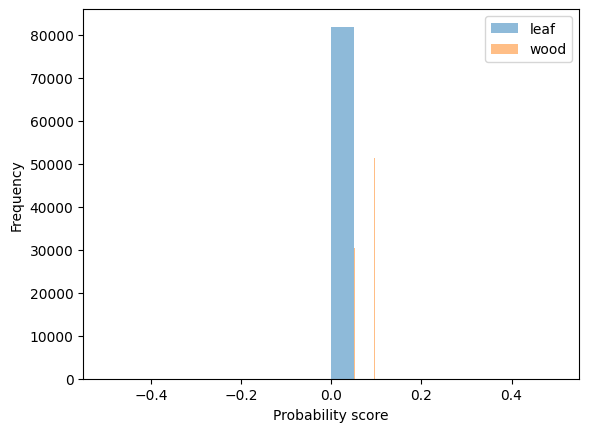

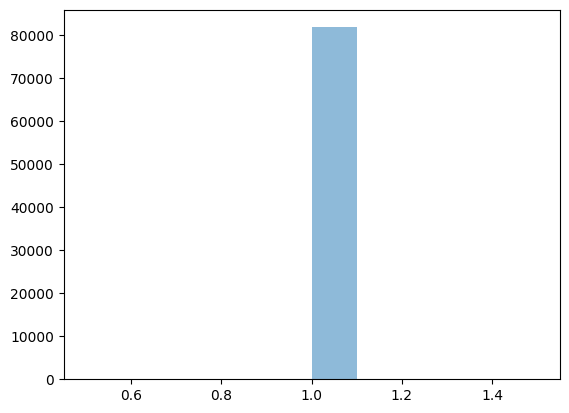

In [7]:
import matplotlib.pyplot as plt

# print('number of points:', dataset[1].get('point').shape[0])

scores = result['predict_scores']

plt.hist(scores[:, 0], alpha=0.5, bins=20, label='leaf')
plt.hist(scores[:, 1], alpha=0.5, bins=20, label='wood')

# Add labels and legend
plt.xlabel('Probability score')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

labels = result['predict_labels']

plt.hist(labels, alpha=0.5, label='Column 1')
plt.show()